Reanalysis of [No evidence for correlations between handgrip strength and sexually dimorphic acoustic properties of voices](https://www.biorxiv.org/content/early/2017/11/30/227165).  
Data and R code see https://osf.io/na2sb/

## Environment setups

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

%pylab inline
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

plt.style.use('ggplot')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Populating the interactive namespace from numpy and matplotlib


In [2]:
%watermark -v -m -p numpy,pandas,seaborn,pymc3,matplotlib

CPython 3.5.2
IPython 5.3.0

numpy 1.13.3
pandas 0.21.0
seaborn 0.8.1
pymc3 3.2
matplotlib 2.0.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-47-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


## Load data, display descriptive result
I resaved the data into csv format

In [3]:
tbl = pd.read_csv('final_dataset.csv', ',')
tbl.head()

ID   sex   age ethnicity   HGS        F0     F0SD      Df_Puts   Pf_Puts  \
0   4  male  19.0   Chinese  45.5  114.5832  14.0137   996.500000 -0.175121   
1   7  male  27.0   Chinese  31.0  147.4819  15.3037   981.033333  0.142022   
2   8  male  24.1   Chinese  40.0  123.3256  12.6864   977.000000 -0.781828   
3  19  male  22.5   Chinese  37.0  120.1835  12.5944  1036.966667 -0.375867   
4  21  male  20.1   Chinese  45.0   94.6771  27.3972   892.500000 -1.741636   

    VTL_Reby  
0  15.923498  
1  15.779474  
2  16.824111  
3  15.858461  
4  18.364027

The main variables is handgrip strength (HGS) and acoustic properties of voices.

In [4]:
(tbl[['age', 'HGS', 'F0', 'F0SD', 'Df_Puts',
       'Pf_Puts', 'VTL_Reby']]
 .agg(['count', 'mean', 'std'])).T.round(3)

count      mean     std
age       221.0    23.401   4.358
HGS       221.0    32.636  10.652
F0        221.0   166.269  55.524
F0SD      221.0    27.450  19.599
Df_Puts   221.0  1069.641  84.829
Pf_Puts   221.0     0.000   0.947
VTL_Reby  221.0    15.678   1.254

In [5]:
(tbl.groupby(['ethnicity', 'sex'])['age']
 .agg(['count'])).T.round(3)

ethnicity Chinese      White_UK     
sex        female male   female male
count          53   53       57   58

Descriptive data summary and display

In [6]:
def btCI(x):
    return sns.utils.ci(sns.algorithms.bootstrap(x, n_boot=1000))
def btCI_025(x):
    return btCI(x)[0]
def btCI_975(x):
    return btCI(x)[1]

In [7]:
(tbl.groupby(['ethnicity', 'sex'])[['age', 'HGS', 'F0', 'F0SD', 'Df_Puts',
       'Pf_Puts', 'VTL_Reby']]
 .agg(['mean', btCI_025, btCI_975, 'std'])).T.round(3)

ethnicity           Chinese            White_UK          
sex                  female      male    female      male
age      mean        24.104    24.843    21.830    22.986
         btCI_025    23.428    23.811    21.007    21.713
         btCI_975    24.823    26.120    22.709    24.373
         std          2.699     4.384     3.539     5.636
HGS      mean        23.566    41.170    24.939    40.690
         btCI_025    22.566    39.169    23.762    38.465
         btCI_975    24.567    43.435    26.149    42.923
         std          3.730     8.040     4.579     8.729
F0       mean       220.627   119.640   216.570   109.773
         btCI_025   214.774   115.856   211.386   105.662
         btCI_975   226.551   123.852   222.414   114.002
         std         21.884    14.758    21.067    16.747
F0SD     mean        40.028    13.146    43.134    13.614
         btCI_025    35.590    11.990    38.421    11.928
         btCI_975    45.024    14.414    48.223    15.341
         std         17.429     4.707    19.273     6.495
Df_Puts  mean      1141.819   995.988  1144.691   997.233
         btCI_025  1132.484   982.083  1134.395   987.706
         btCI_975  1151.456  1009.230  1156.020  1007.619
         std         36.814    51.130    42.537    38.974
Pf_Puts  mean         0.805    -0.805     0.843    -0.828
         btCI_025     0.690    -0.968     0.719    -0.930
         btCI_975     0.930    -0.665     0.964    -0.714
         std          0.448     0.551     0.468     0.411
VTL_Reby mean        14.473    16.657    14.674    16.872
         btCI_025    14.353    16.457    14.546    16.737
         btCI_975    14.590    16.891    14.807    16.998
         std          0.448     0.864     0.485     0.524

In [8]:
tbl['subgroup'] = tbl['ethnicity']+'-'+tbl['sex']

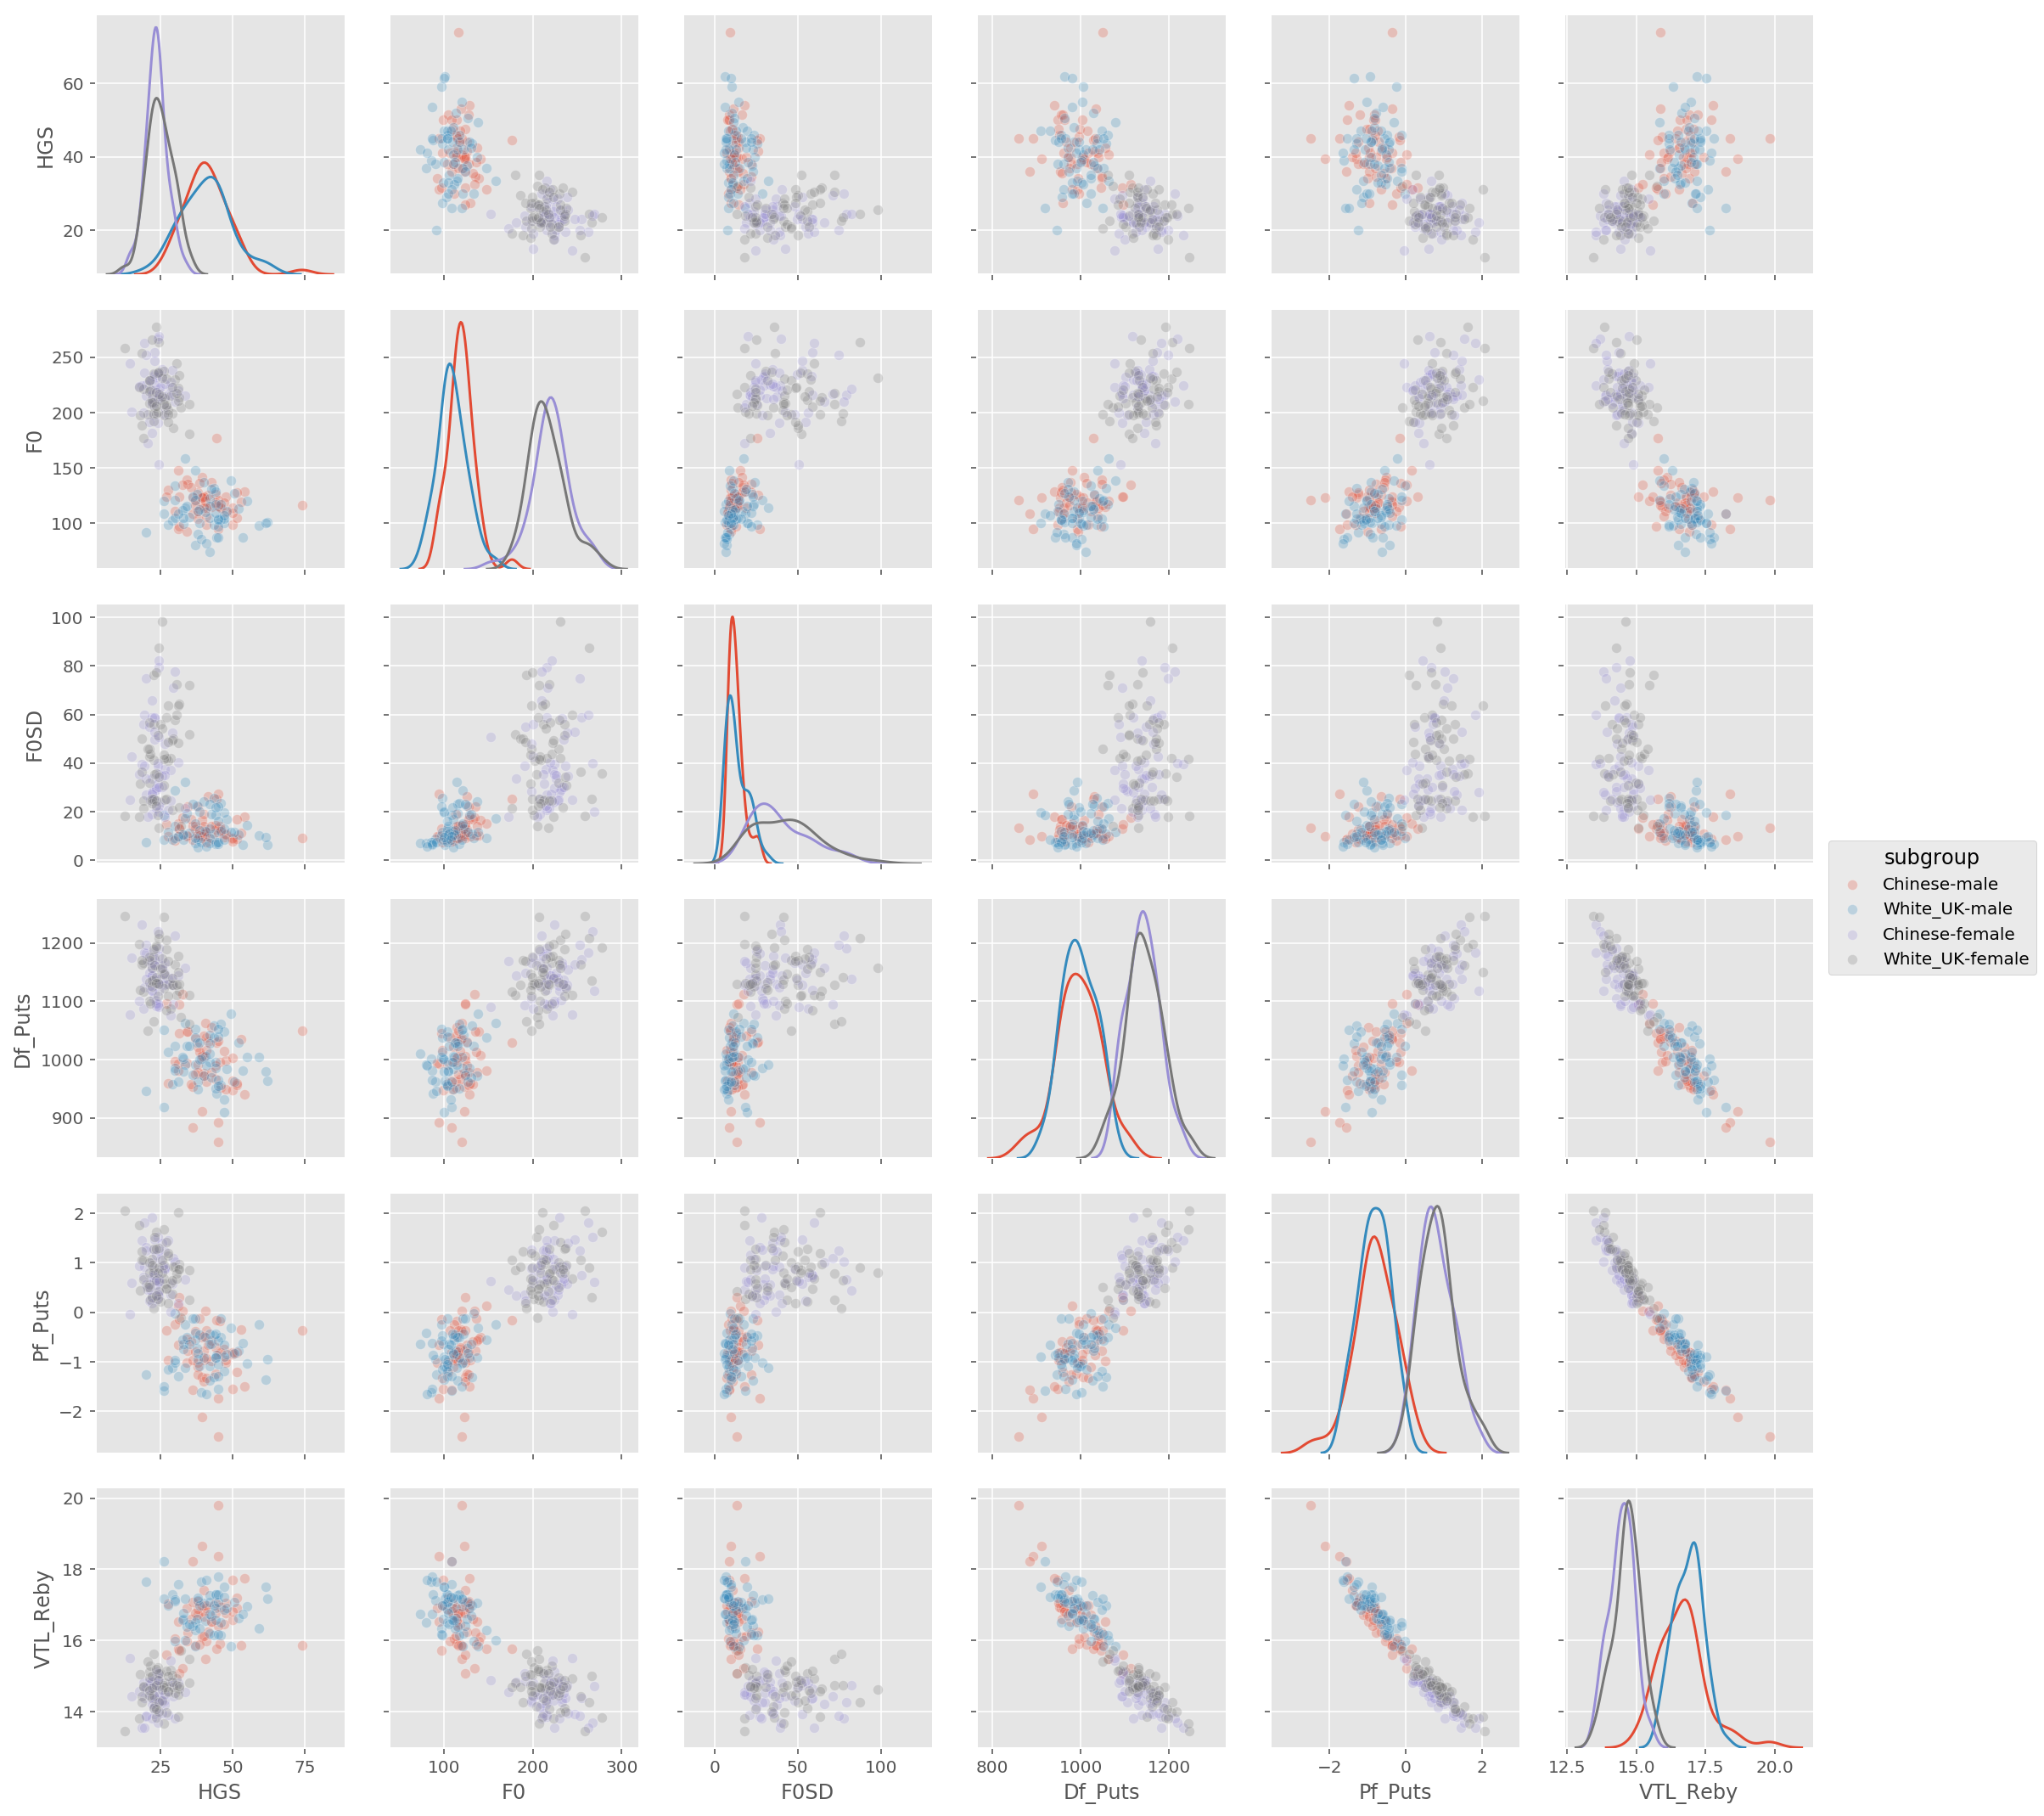

In [9]:
sns.pairplot(tbl, hue='subgroup', 
             vars=['HGS', 'F0', 'F0SD', 'Df_Puts', 'Pf_Puts', 'VTL_Reby'],
             diag_kind='kde',
             plot_kws=dict(alpha=.25));

## Mutivariate Model
The linear regressions reported in the manuscript do not account for the repeated measurements of acoustic properties from each subject. Treating the five acoustic measures as the predictor does not properly quantify noise associated with the measurement. To address this issue, we performed a Bayesian analysis with a Multivariate latent model. Acoustics and handgrip strength within each participant are modeled as a realization of the a latent multivariate normal distribution, with the correlation matrix capturing the relationship between acoustics and handgrip strength. The Bayesian analysis is performed in Python using PyMC3 version 3.2, and the results were displayed using Seaborn and Matplotlib. 

In [10]:
from patsy import dmatrices
_, X  = dmatrices("HGS ~ ethnicity*sex", data=tbl, return_type='matrix')
Terms = X.design_info.column_names
X = np.asarray(X) # design matrix
datamat = tbl[['HGS', 'F0', 'F0SD', 'Df_Puts', 'Pf_Puts', 'VTL_Reby']].values # data
nsbj, npredi = X.shape
Nmeasure = datamat.shape[1]
Terms

['Intercept',
 'ethnicity[T.White_UK]',
 'sex[T.male]',
 'ethnicity[T.White_UK]:sex[T.male]']

## Model 1 - Latent correlation model
### Non-centered parameterization
$$
\begin{align*}
R &
\sim \text{LKJCorr}(2)\\
\sigma &
\sim \text{HalfNormal}(50)\\
\text{Prior for coefficients}\\
\beta &
\sim \text{Normal}(0, 100)\\
\Sigma &
= diag(\sigma)*R*diag(\sigma)\\
\mu_{latent} &
\sim \text{MvNormal}(X\beta, \Sigma)\\
observed &
\sim \text{Normal}(\mu_{latent}, \sigma)
\end{align*}
$$

The latent measure follows a prior distribution defined by the six-dimensional Gaussian distribution with means $X\beta$ and covariance matrix cov. In practice, we parameterized the Cholesky decomposition of the covariance matrix. We then performed an affine transformation by multiplying the Cholesky factor of cov with a standard Normal and plus $X\beta$.

In [13]:
with pm.Model() as mv_model1:
    # prior for covariance
    sd_dist = pm.HalfNormal.dist(50)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nmeasure, eta=2, sd_dist=sd_dist)
    
    # compute the covariance and correlation matrix 
    chol = pm.expand_packed_triangular(Nmeasure, packed_chol, lower=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    
    # Extract the standard deviations and rho
    sd = pm.Deterministic('sd', tt.sqrt(tt.diag(cov)))
    corr = pm.Deterministic('corr', tt.diag(sd**-1).dot(cov.dot(tt.diag(sd**-1))))
    
    beta = pm.Normal('beta', mu=0., sd=100., shape=(npredi, Nmeasure))
    mu_ = pm.Normal('mu_', mu=0., sd=1., shape=datamat.shape)
    mu_group = tt.dot(X, beta) + tt.dot(chol, mu_.T).T
    
    # observed
    # sd_ = pm.HalfNormal('sd_', 10, shape=Nmeasure)
    obs = pm.Normal('observed', mu=mu_group, sd=sd, observed=datamat)
    
    trace1 = pm.sample(1000, tune=2000, njobs=4,
                       # nuts_kwargs=dict(target_accept=.95, max_treedepth=15)
                      )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_, beta, chol_cov_cholesky_cov_packed__]
100%|██████████| 3000/3000 [07:23<00:00,  6.76it/s]


The probabilistic model was built using PyMC3 and we sampled from the posterior distribution using No-U-Turn Sampler (NUTS). We ran four MCMC chains with 3000 samples. The first 1000 samples were used for tuning the mass matrix and step size for NUTS and were discarded following this. Model convergence was diagnosed by computing Gelman and Rubin's convergence diagnostic (R-hat, 1992), examining the effective sample size, inspecting the mixing of the traces, and checking whether there is any divergent sample that has been returned from the sampler. 

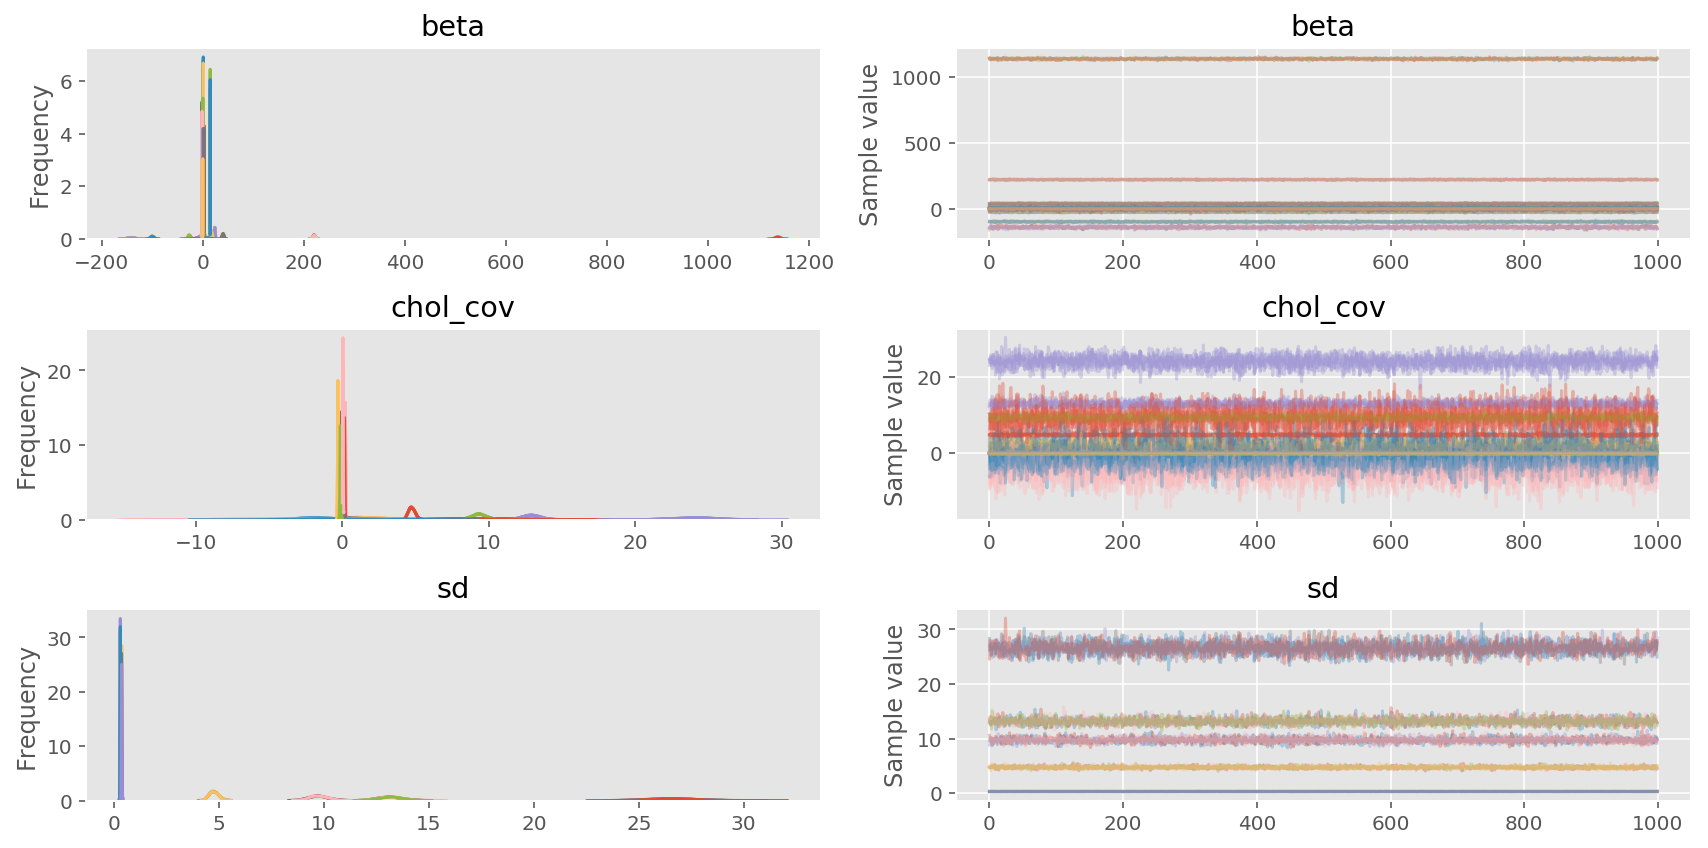

In [14]:
pm.traceplot(trace1, varnames=['beta', 'chol_cov', 'sd']);

In [23]:
measure_labels = ['HGS', 'F0', 'F0SD', 'Df_Puts', 'Pf_Puts', 'VTL_Reby']

data_demean = np.zeros_like(datamat)
for ig in tbl['subgroup'].unique():
    data_demean[tbl['subgroup']==ig, :] = datamat[tbl['subgroup']==ig, :] - \
                                datamat[tbl['subgroup']==ig, :].mean(axis=0)

empirical_corr = pd.DataFrame(np.corrcoef(data_demean.T),
                             columns=measure_labels,
                             index=measure_labels)

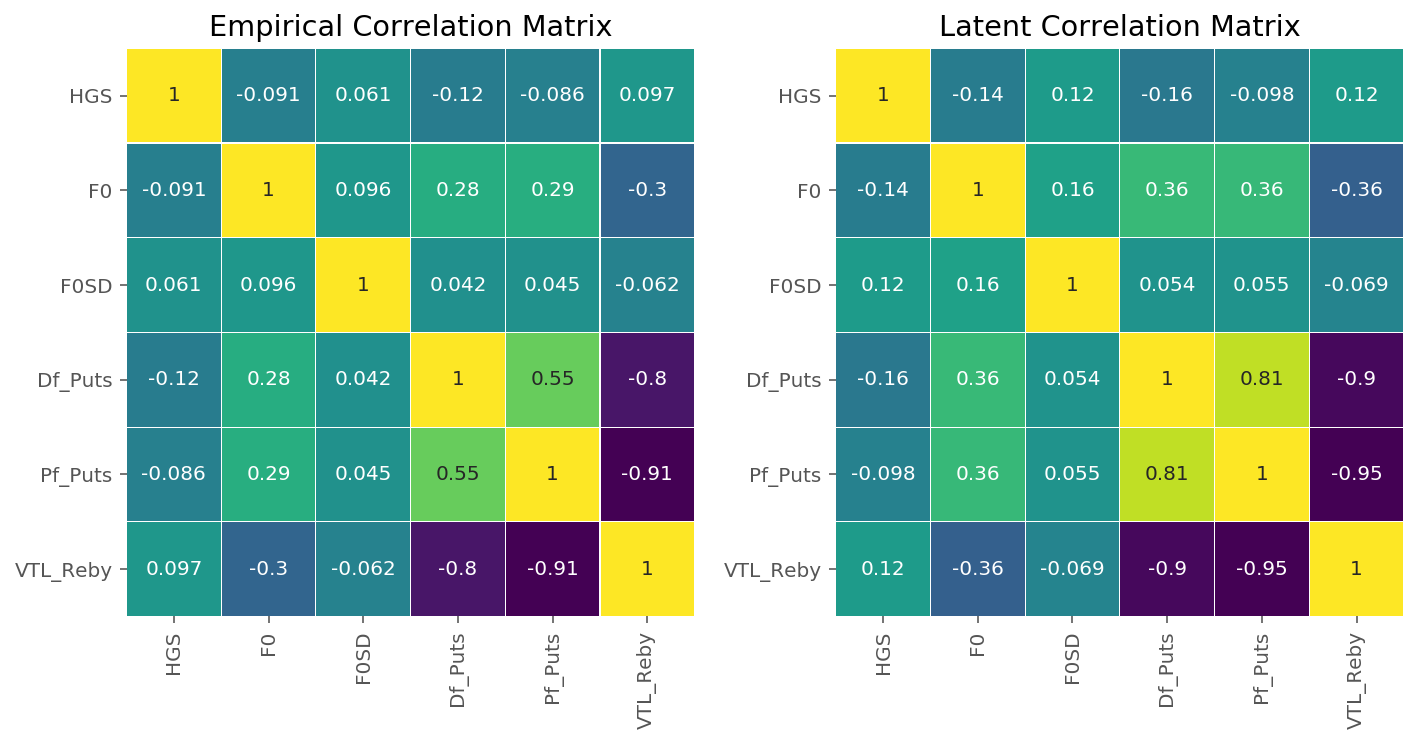

In [15]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(empirical_corr, 
            cbar=False, square = True, annot=True, 
            linewidths=.1, cmap='viridis', ax=ax[0])
ax[0].set_title('Empirical Correlation Matrix')

posterior_corr = pd.DataFrame(trace1['corr'].mean(axis=0),
                             columns=measure_labels,
                             index=measure_labels)
sns.heatmap(posterior_corr, 
            cbar=False, square = True, annot=True, 
            linewidths=.1, cmap='viridis', ax=ax[1])
ax[1].set_title('Latent Correlation Matrix')

plt.tight_layout();

### Posterior distribution of the cross correlation
Similar conclusion to the paper could be drawn: The posterior distribution of the correlations between handgrip strength and acoustic measures overlap with zero.

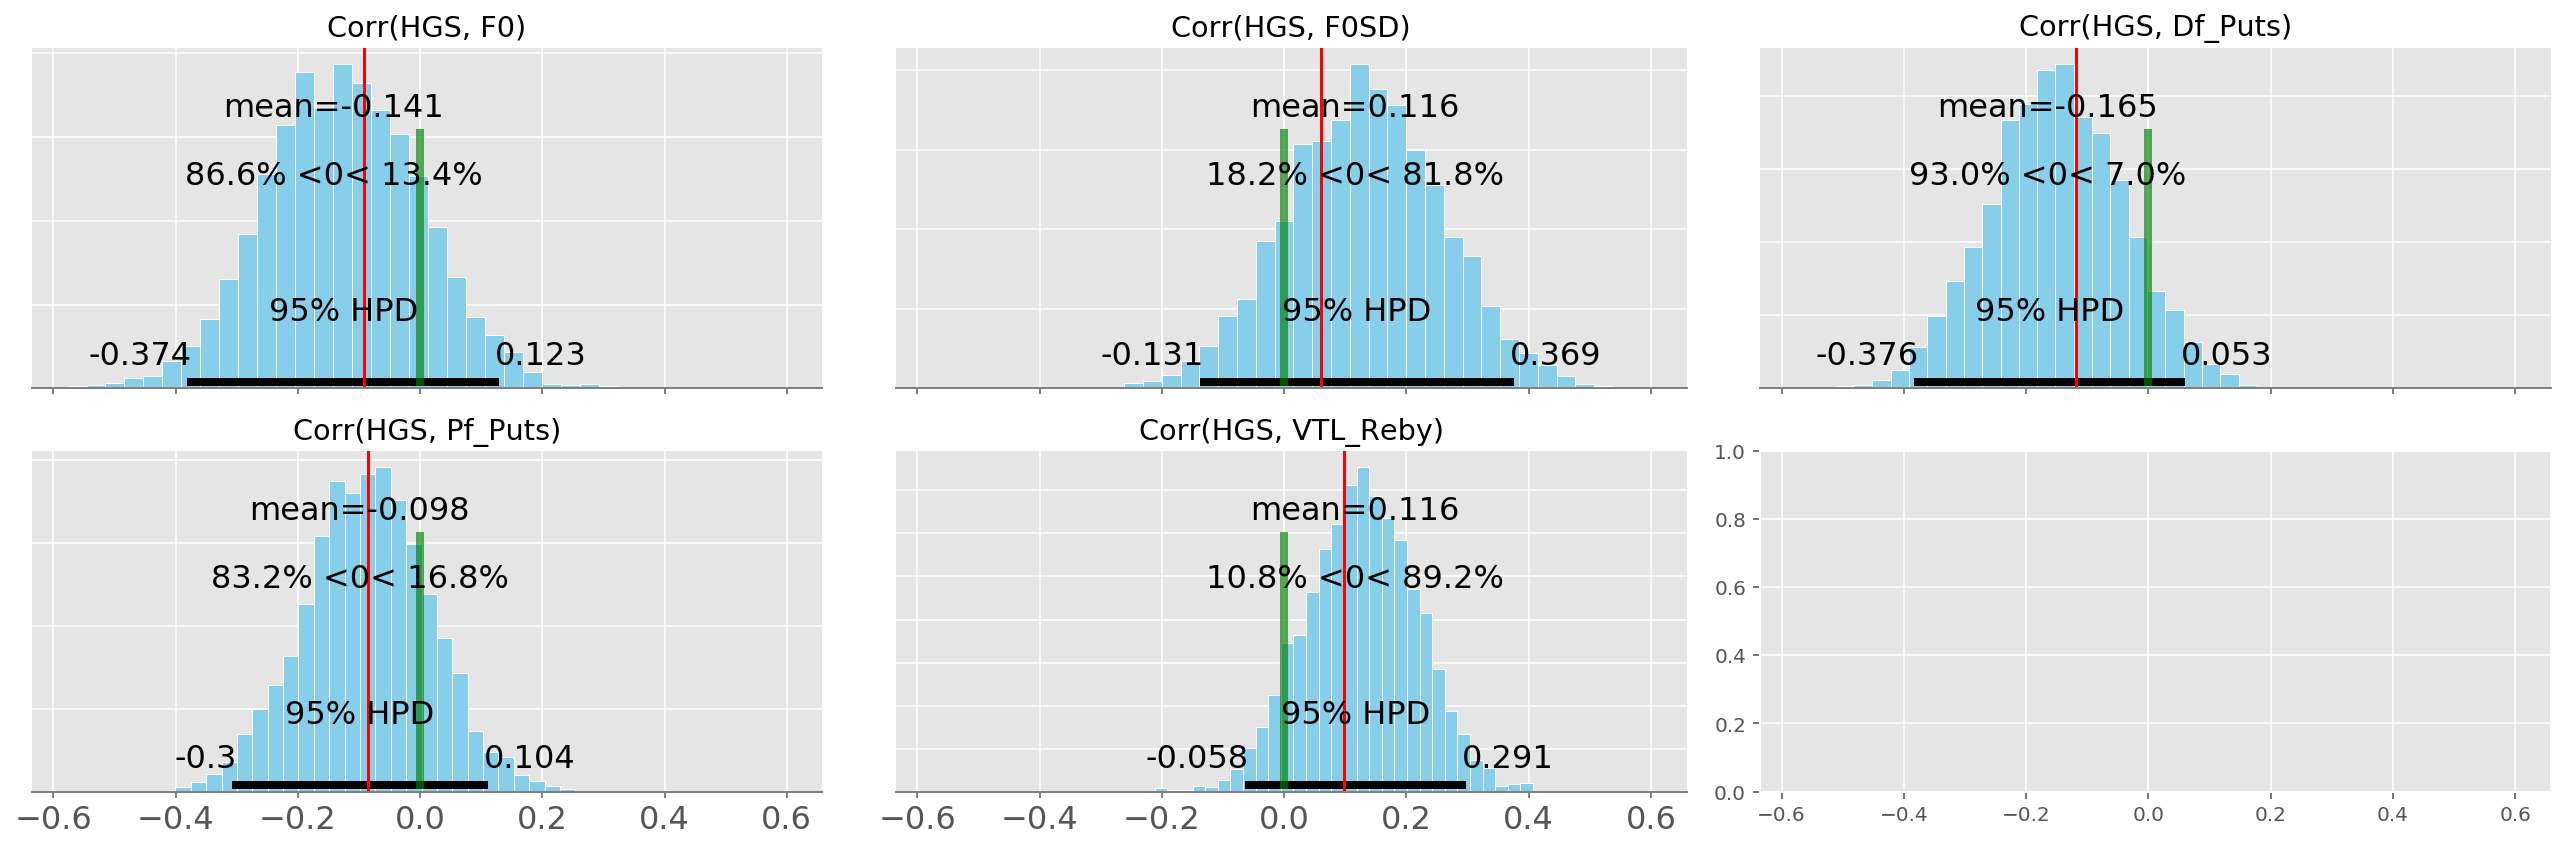

In [16]:
plotpost = pm.plots.artists.plot_posterior_op

_,  ax = plt.subplots(2, 3, figsize=(18, 6), sharex=True)
corrtrace = trace1['corr'][:, 0, :]
ax1 = ax.flatten()
for i, measure in enumerate(measure_labels):
    if i>0:
        trace_values = corrtrace[:, i]
        plotpost(trace_values, ax1[i-1], kde_plot=False, point_estimate='mean', 
                 round_to=3, alpha_level=0.05, ref_val=0., rope=None, color='#87ceeb')
        ax1[i-1].axvline(empirical_corr.values[0, i], color='r')
        ax1[i-1].set_title('Corr('+measure_labels[0]+', '+measure+')')
plt.tight_layout();

### Check model fit by ploting the posterior prediction with the actual observed

In [17]:
ppc1 = pm.sample_ppc(trace1, model=mv_model1, samples=100)

100%|██████████| 100/100 [00:00<00:00, 276.93it/s]


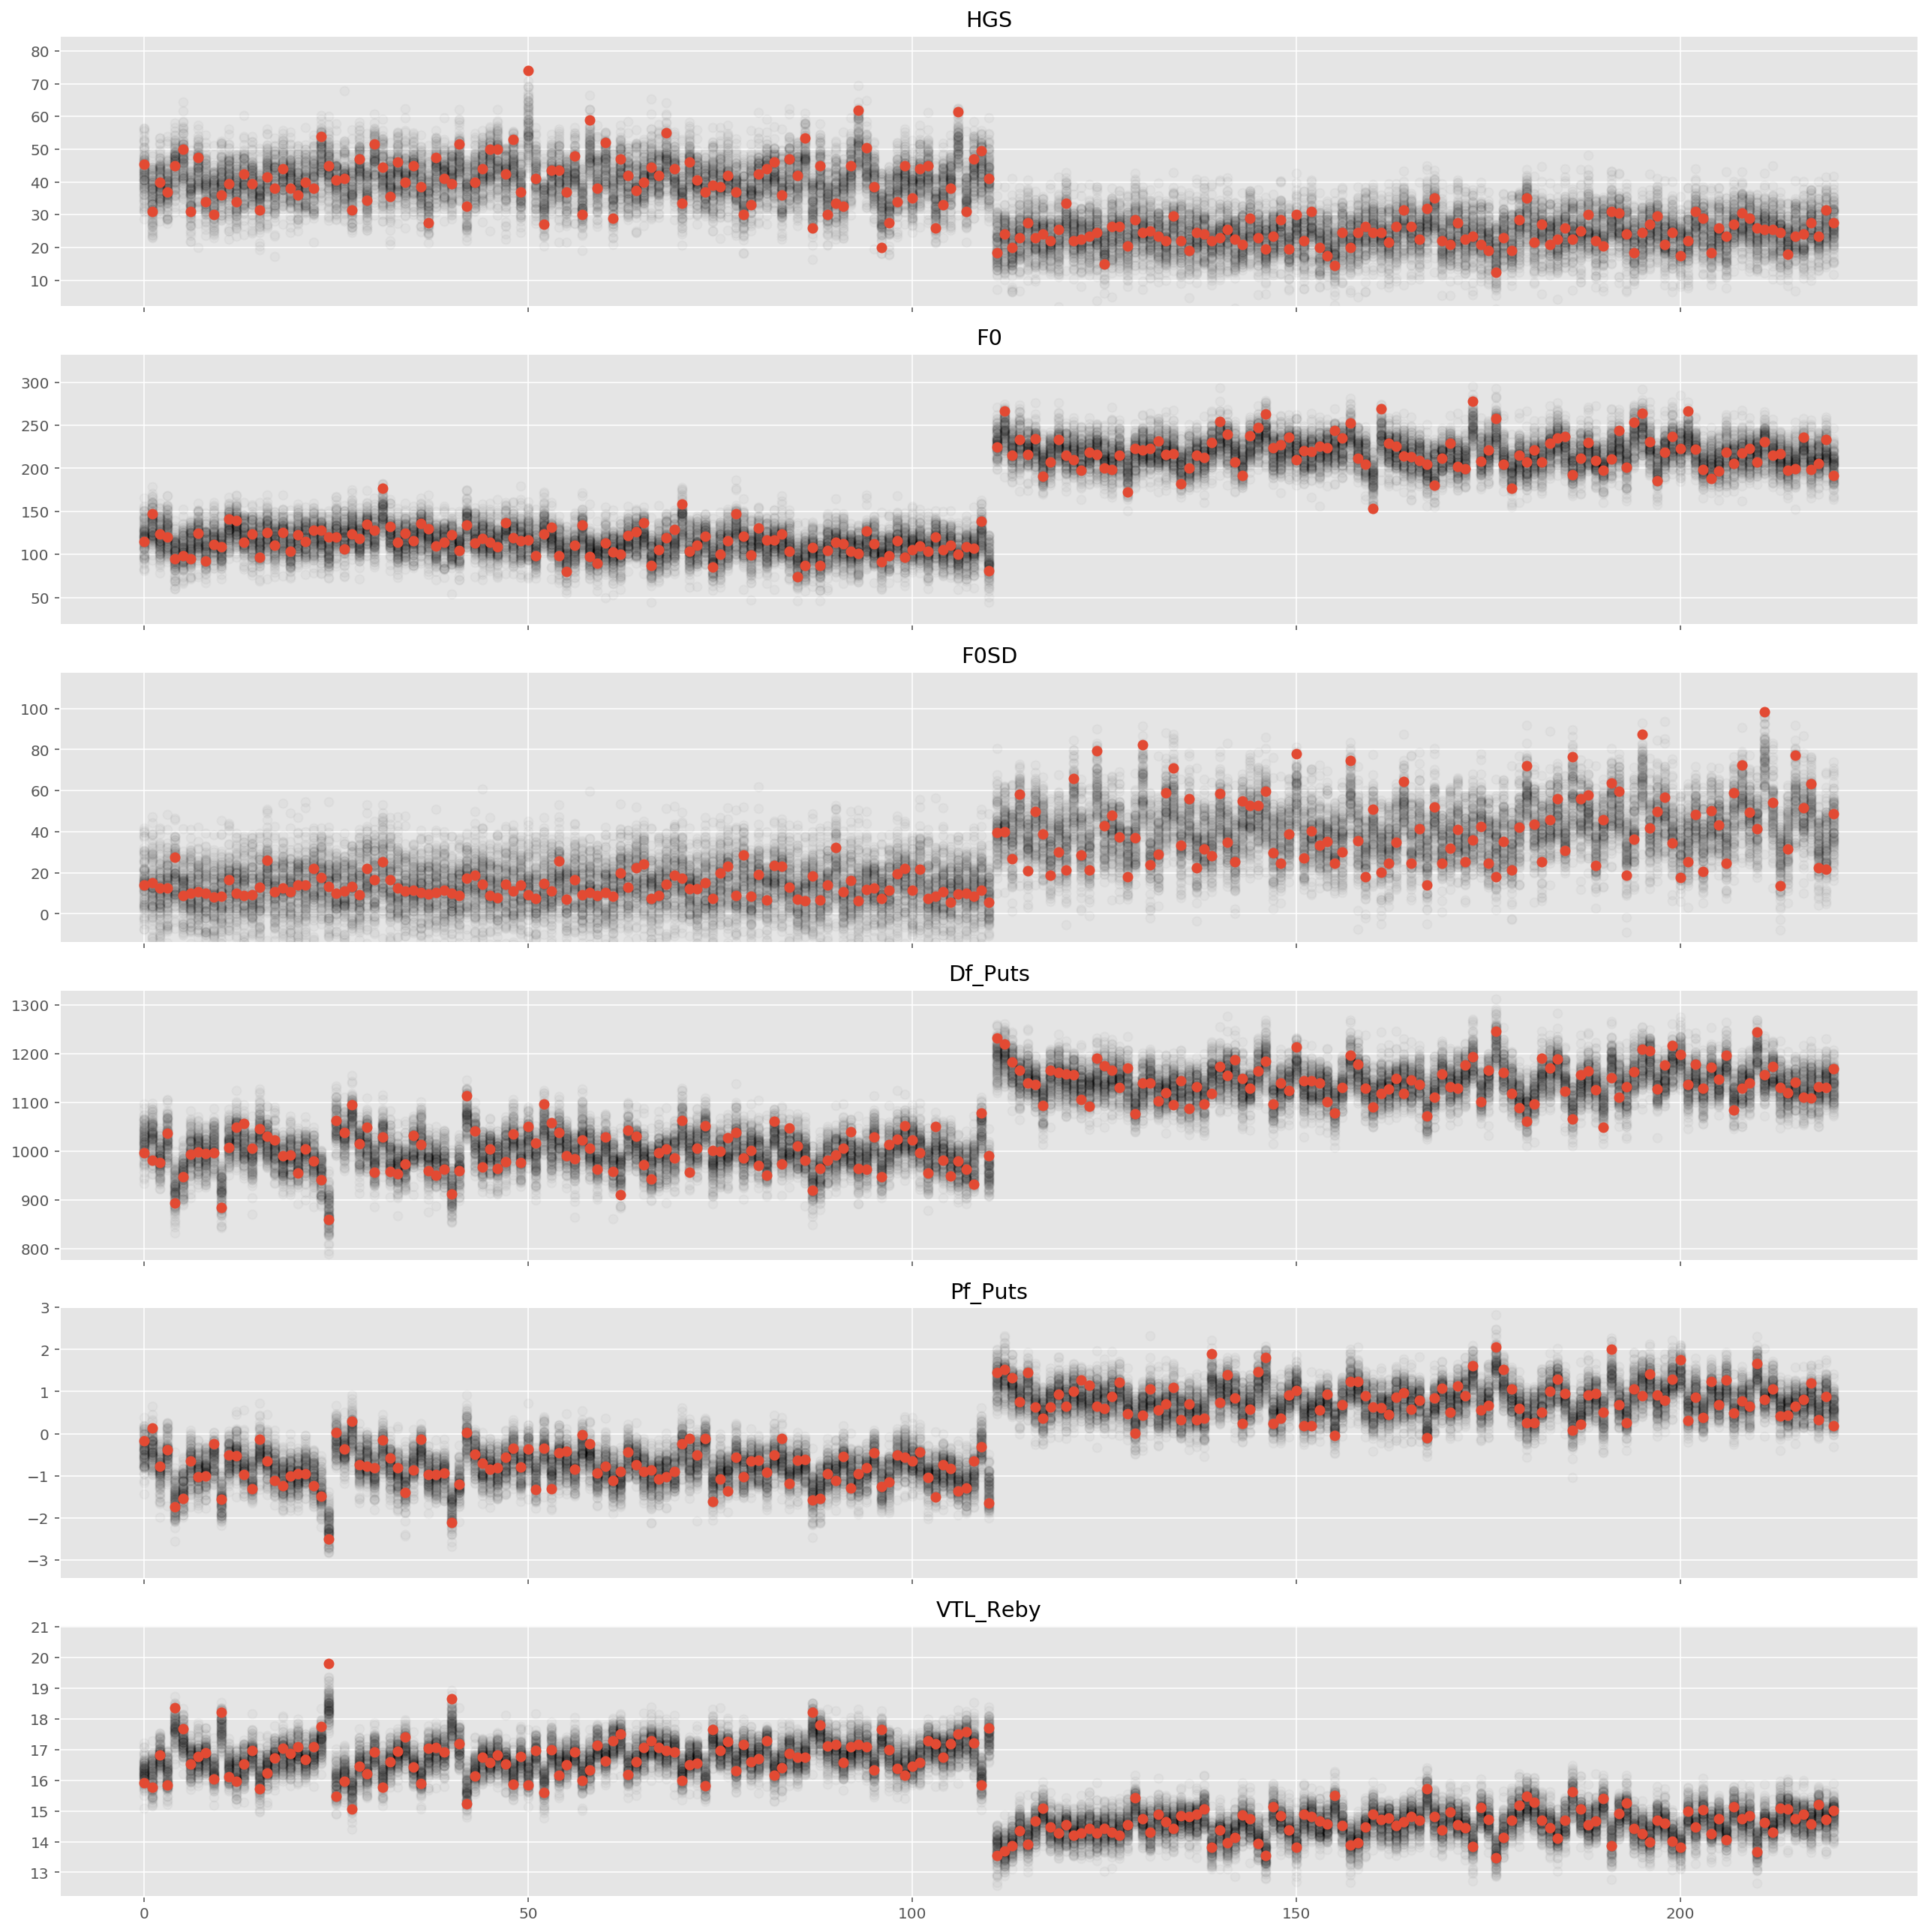

In [18]:
_, ax = plt.subplots(Nmeasure, 1, figsize=(18, 18), sharex=True)
for i in range(Nmeasure):
    ax[i].plot(ppc1['observed'][:,:,i].T, 'o', color='k', alpha=.025)
    ax[i].plot(datamat[:,i].T, 'o')
    ax[i].set_title(measure_labels[i])
    ax[i].set_ylim(datamat[:,i].min()-np.std(datamat[:,i]),
                   datamat[:,i].max()+np.std(datamat[:,i]))
plt.tight_layout();

In [21]:
CONVERGENCE_TITLE = lambda: 'BFMI = {a:.2f}\nmax(R_hat) = {b:.3f}\nmin(Eff_n) = {c:.3f}'\
                    .format(a=bfmi, b=max_gr, c=min_effn)
def get_diags(trace):
    bfmi = pm.bfmi(trace)
    max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())
    min_effn = min(np.median(ef_stats) for ef_stats in pm.effective_n(trace).values())
    return bfmi, max_gr, min_effn

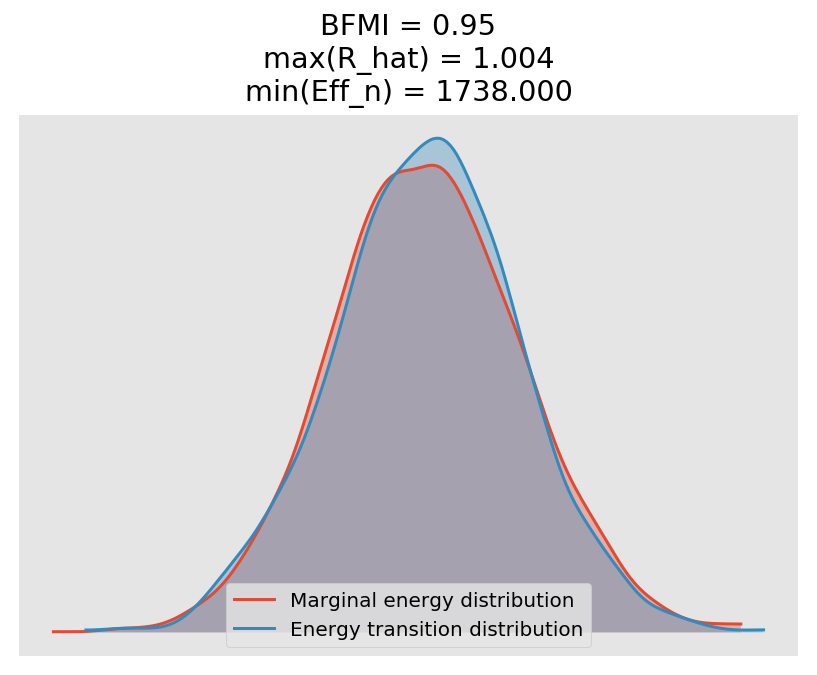

In [20]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

bfmi, max_gr, min_effn = get_diags(trace1)
(pm.energyplot(trace1, ax=ax)
   .set_title(CONVERGENCE_TITLE()));

### Compare with a bootstrap distribution from a frequentist estimator

In [29]:
nboot = 4000
corr_boot = np.zeros_like(trace1['corr'])
for ib in range(nboot):
    boot_idx = np.random.choice(nsbj, nsbj)
    corr_boot[ib, :, :] = np.corrcoef(data_demean[boot_idx, :].T)

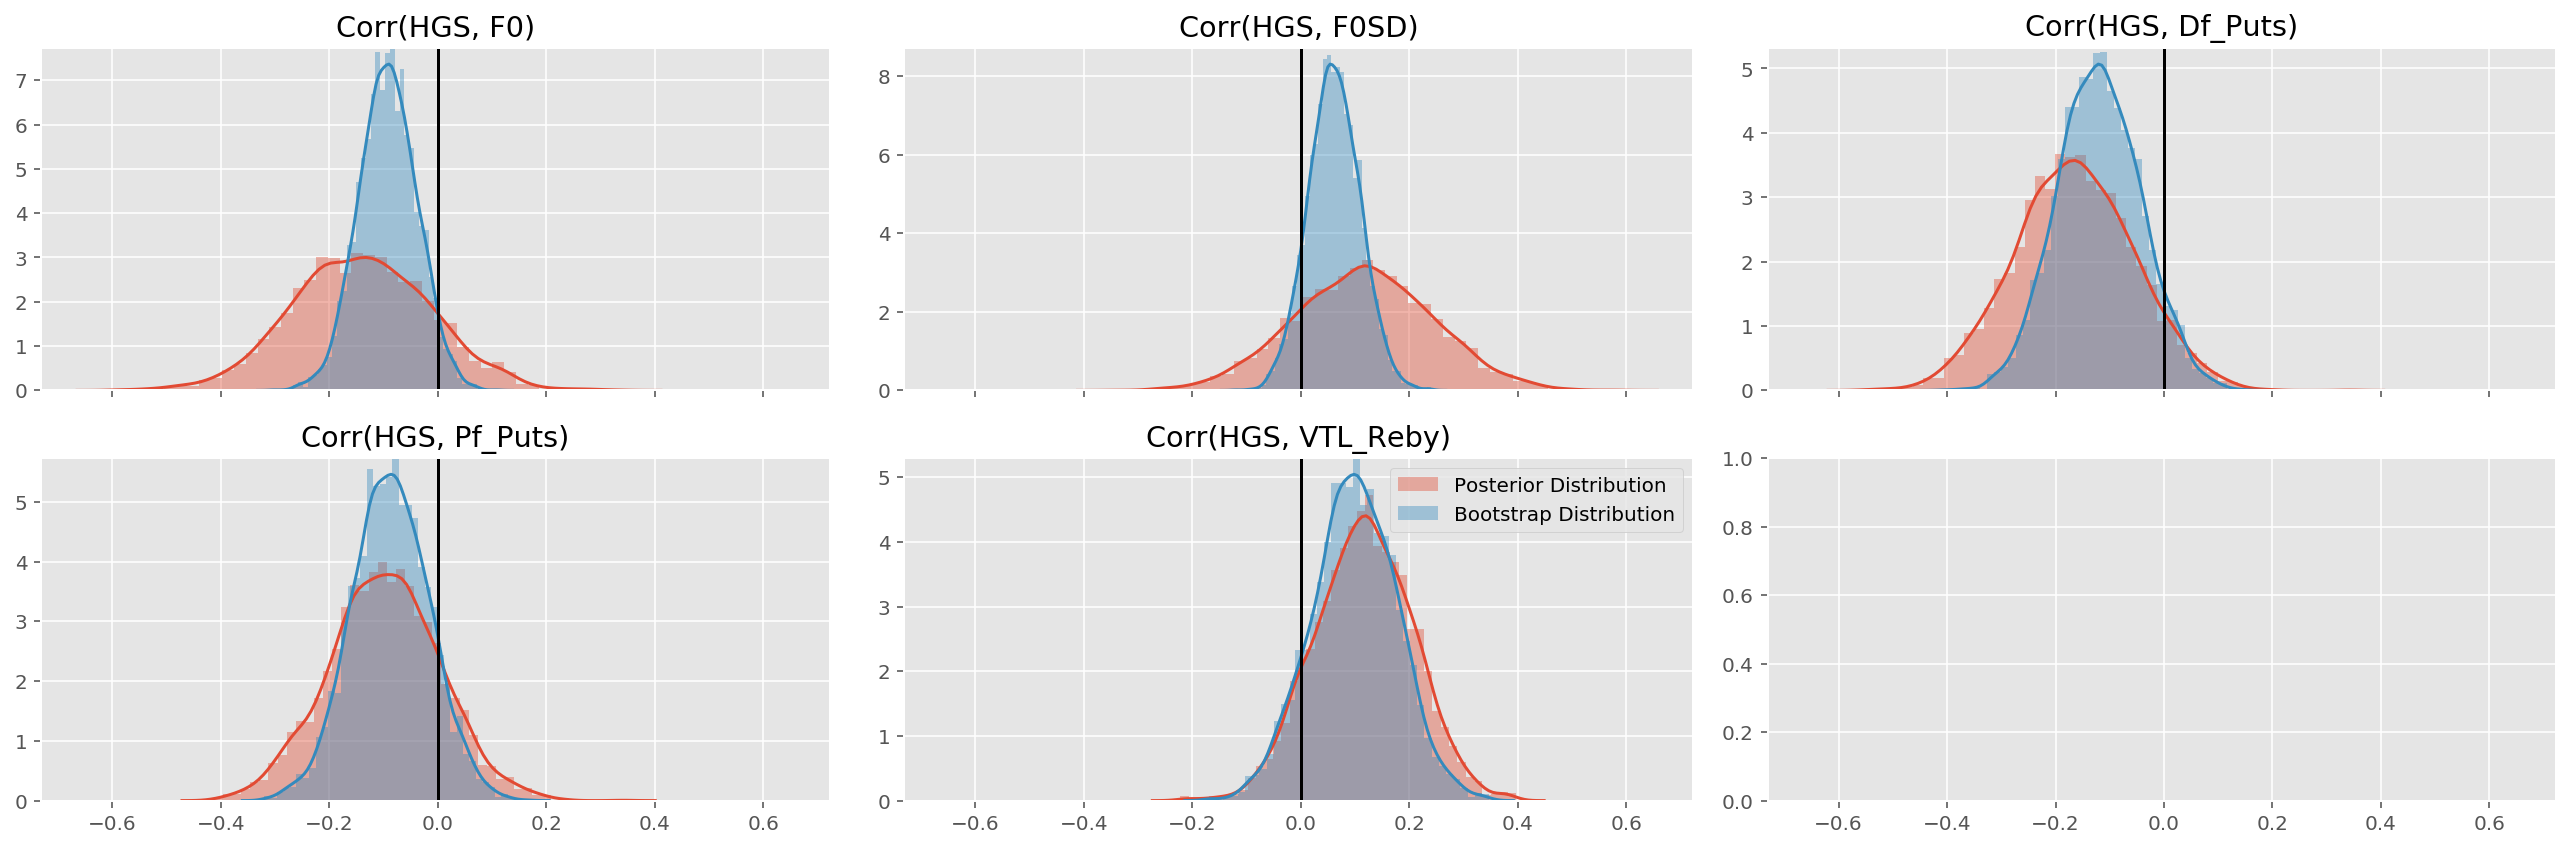

In [22]:
_,  ax = plt.subplots(2, 3, figsize=(18, 6), sharex=True)
ax1 = ax.flatten()
for i, measure in enumerate(measure_labels):
    if i>0:
        val1 = trace1['corr'][:, 0, i]
        sns.distplot(val1, kde=True, ax=ax1[i-1],
                         label='Posterior Distribution')
        val2 = corr_boot[:, 0, i]
        sns.distplot(val2, kde=True, ax=ax1[i-1],
                         label='Bootstrap Distribution')
        ax1[i-1].set_title('Corr('+measure_labels[0]+', '+measure+')')
        ax1[i-1].axvline(0, color='k')
ax1[i-1].legend()
plt.tight_layout();

## Model 2 - direct observed model
### Centered parameterization
$$
\begin{align*}
R &
\sim \text{LKJCorr}(1)\\
\sigma &
\sim \text{HalfNormal}(50)\\
\text{Prior for group and measurement}\\
\mu &
\sim \text{Normal}(\overline{measure}, 100)\\
\Sigma &
= diag(\sigma)*R*diag(\sigma)\\
observed &
\sim \text{MvNormal}(\mu, \Sigma)
\end{align*}
$$

Alternatively, we treat the observed measurement as is and modelled it directly using a multivariate normal distribution.

In [36]:
X1 = {c:(tbl[c]
        .replace(dict(zip(tbl[c].unique(), np.arange(len(tbl[c].unique())))))
        .values) 
     for c in ['subgroup', 'ethnicity', 'sex']}

Ng = len(np.unique(X1['subgroup']))

X1['subgroup']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [37]:
with pm.Model() as mv_model:
    # prior for covariance
    sd_dist = pm.HalfNormal.dist(50)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nmeasure, eta=1, sd_dist=sd_dist)
    
    # compute the covariance and correlation matrix 
    chol = pm.expand_packed_triangular(Nmeasure, packed_chol, lower=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    # Extract the standard deviations and rho
    sd = pm.Deterministic('sd', tt.sqrt(tt.diag(cov)))
    corr = pm.Deterministic('corr', tt.diag(sd**-1).dot(cov.dot(tt.diag(sd**-1))))
    
    beta = pm.Normal('beta', mu=datamat.mean(axis=0), sd=100., shape=(Ng, Nmeasure))
    # observed
    obs = pm.MvNormal('observed', 
                      mu=beta[X1['subgroup'], :],
                      chol=chol, 
                      observed=datamat)
    
    trace = pm.sample(1000, tune=2000, njobs=4
#                        nuts_kwargs=dict(target_accept=.95, max_treedepth=15)
                      )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, chol_cov_cholesky_cov_packed__]
INFO:pymc3:NUTS: [beta, chol_cov_cholesky_cov_packed__]
100%|██████████| 3000/3000 [05:08<00:00,  9.73it/s]


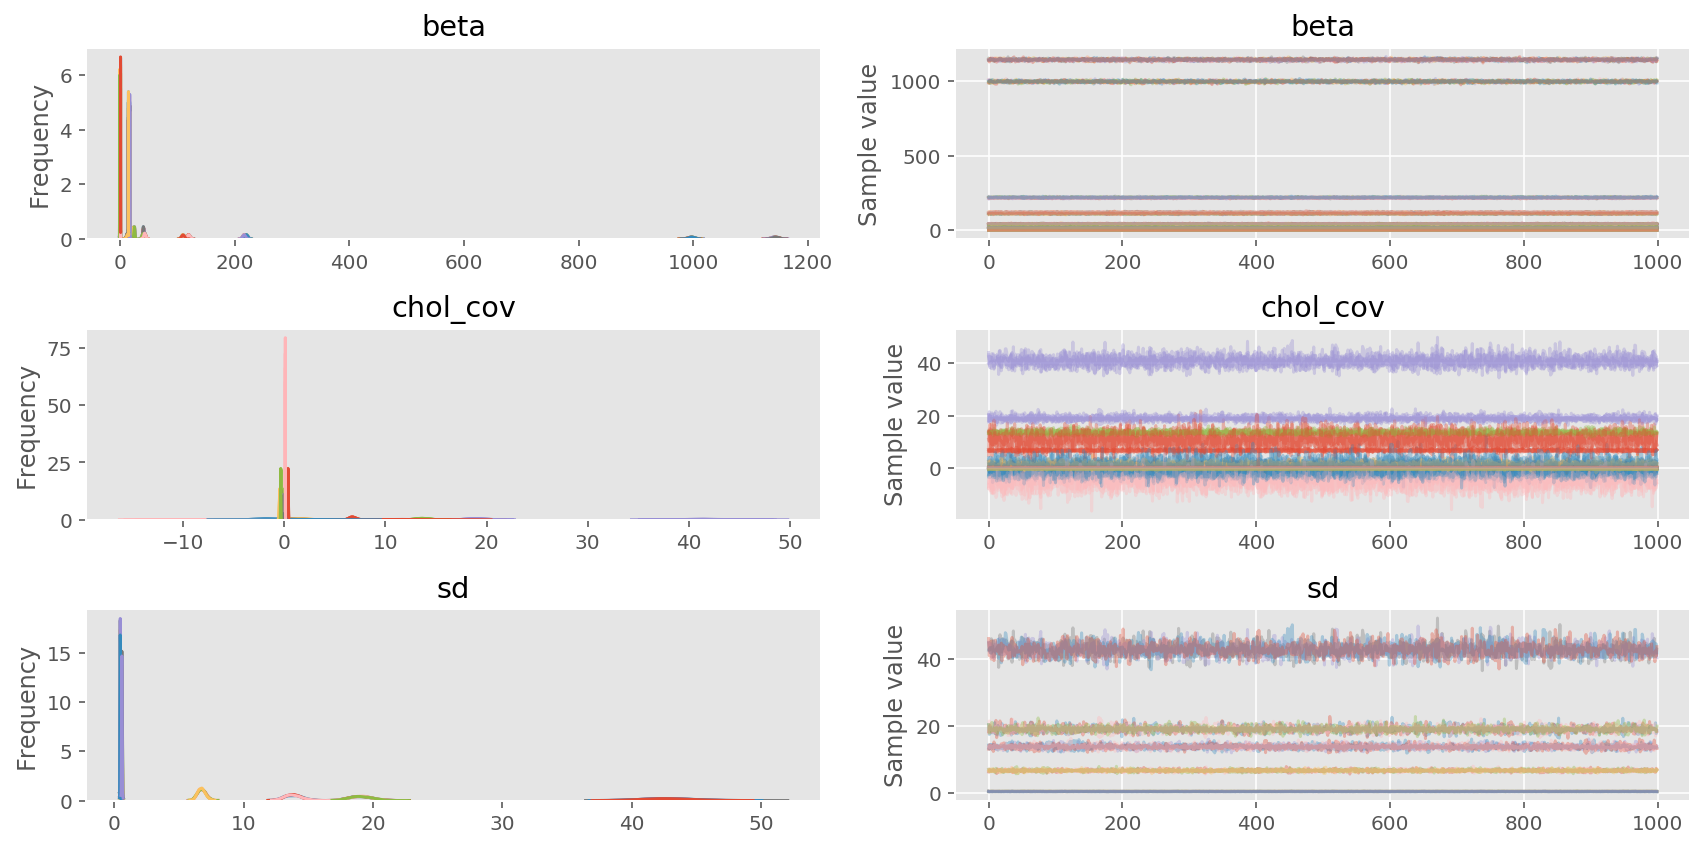

In [42]:
pm.traceplot(trace, varnames=['beta', 'chol_cov', 'sd']);

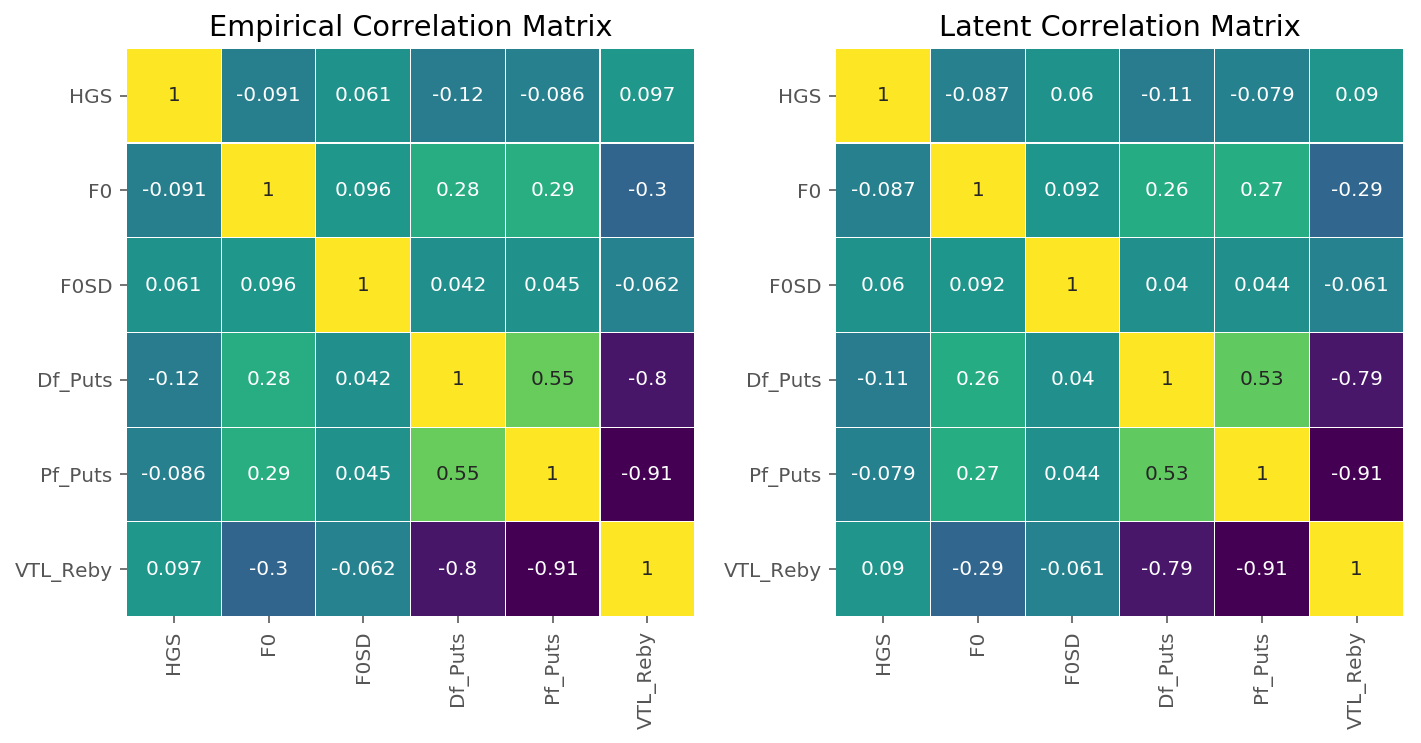

In [38]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(empirical_corr, 
            cbar=False, square = True, annot=True, 
            linewidths=.1, cmap='viridis', ax=ax[0])
ax[0].set_title('Empirical Correlation Matrix')

posterior_corr = pd.DataFrame(trace['corr'].mean(axis=0),
                              columns=measure_labels,
                              index=measure_labels)
sns.heatmap(posterior_corr, 
            cbar=False, square = True, annot=True, 
            linewidths=.1, cmap='viridis', ax=ax[1])
ax[1].set_title('Latent Correlation Matrix')

plt.tight_layout();

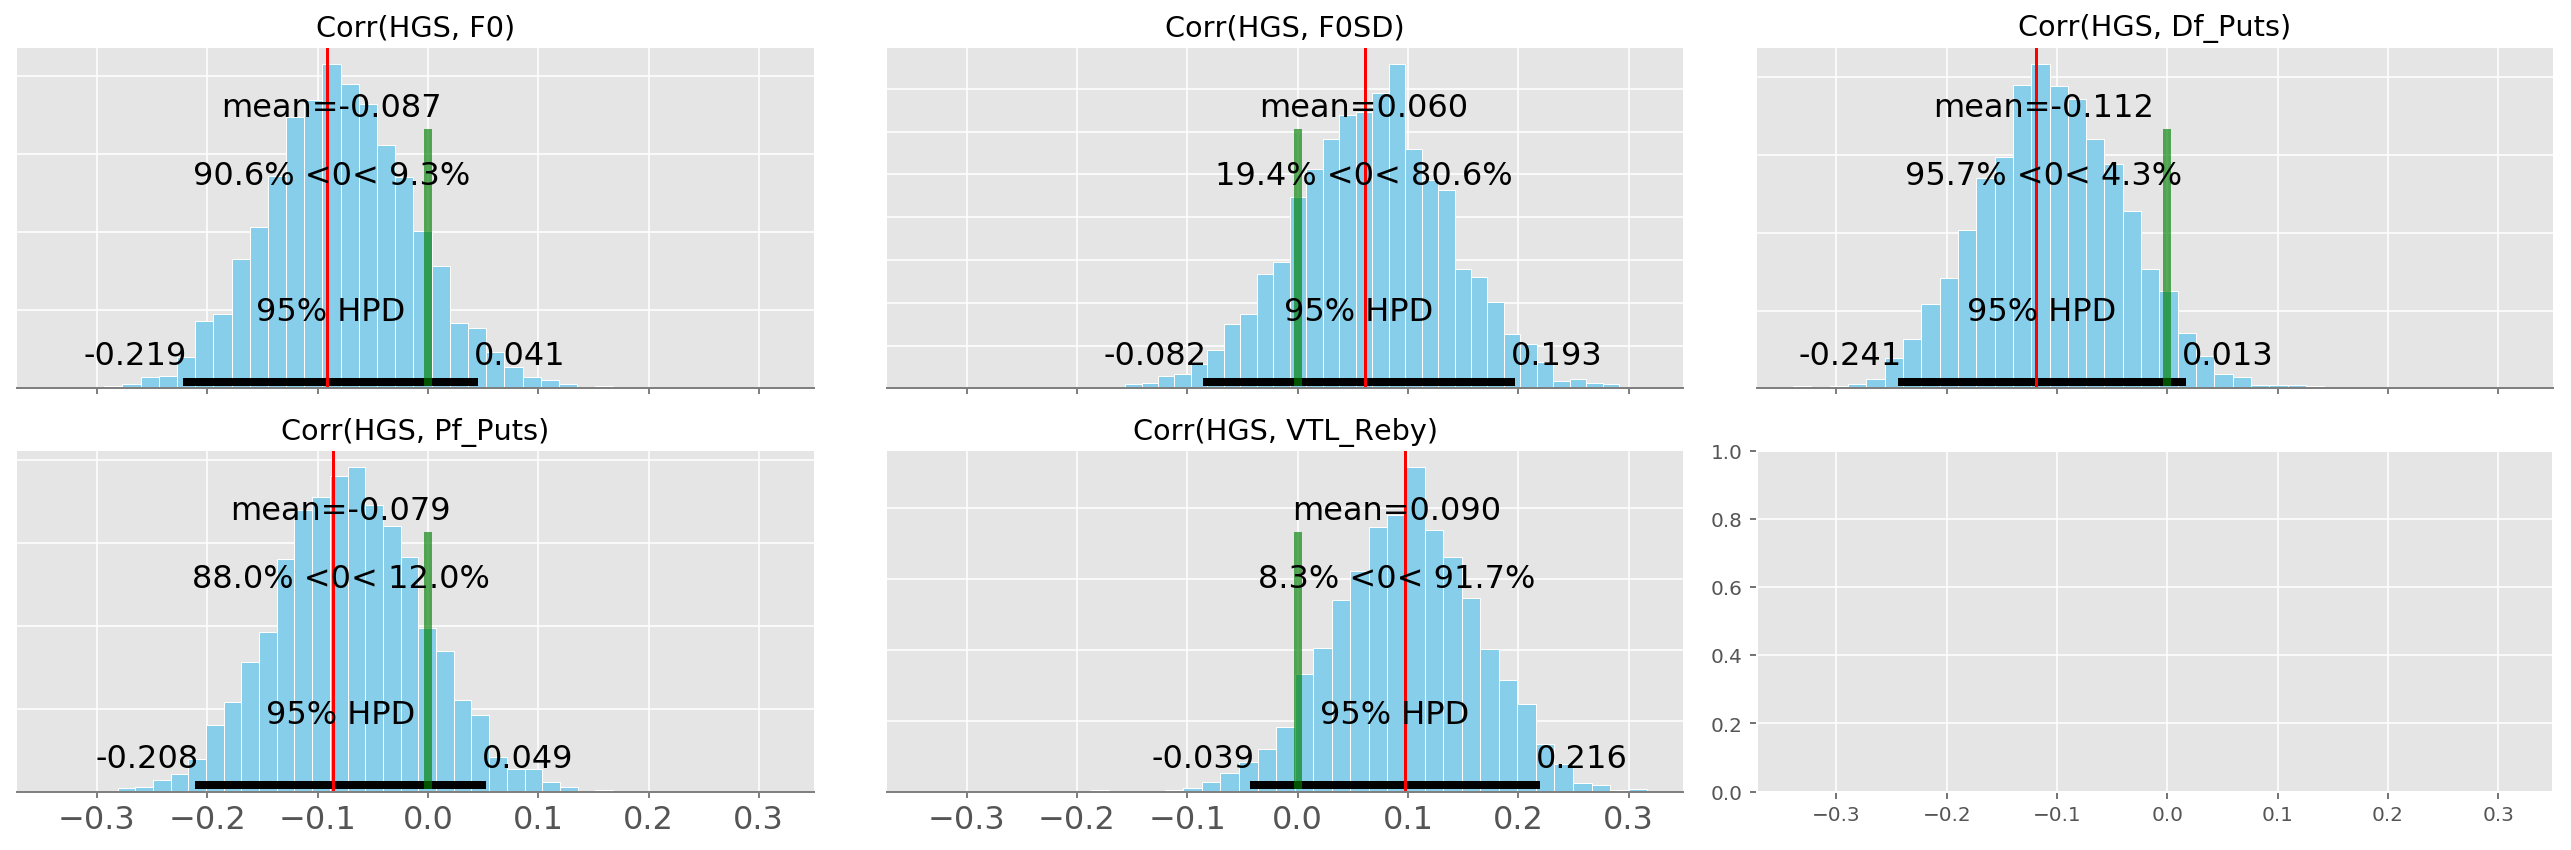

In [39]:
plotpost = pm.plots.artists.plot_posterior_op

_,  ax = plt.subplots(2, 3, figsize=(18, 6), sharex=True)
corrtrace = trace['corr'][:, 0, :]
ax1 = ax.flatten()
for i, measure in enumerate(measure_labels):
    if i>0:
        trace_values = corrtrace[:, i]
        plotpost(trace_values, ax1[i-1], kde_plot=False, point_estimate='mean', 
                 round_to=3, alpha_level=0.05, ref_val=0., rope=None, color='#87ceeb')
        ax1[i-1].axvline(empirical_corr.values[0, i], color='r')
        ax1[i-1].set_title('Corr('+measure_labels[0]+', '+measure+')')
plt.tight_layout();

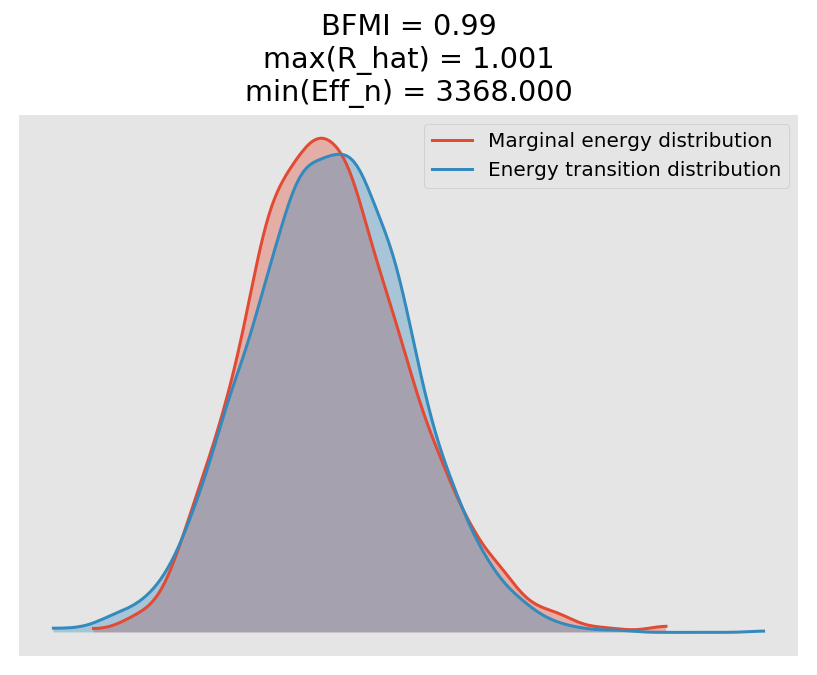

In [40]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

bfmi, max_gr, min_effn = get_diags(trace)
(pm.energyplot(trace, ax=ax)
   .set_title(CONVERGENCE_TITLE()));

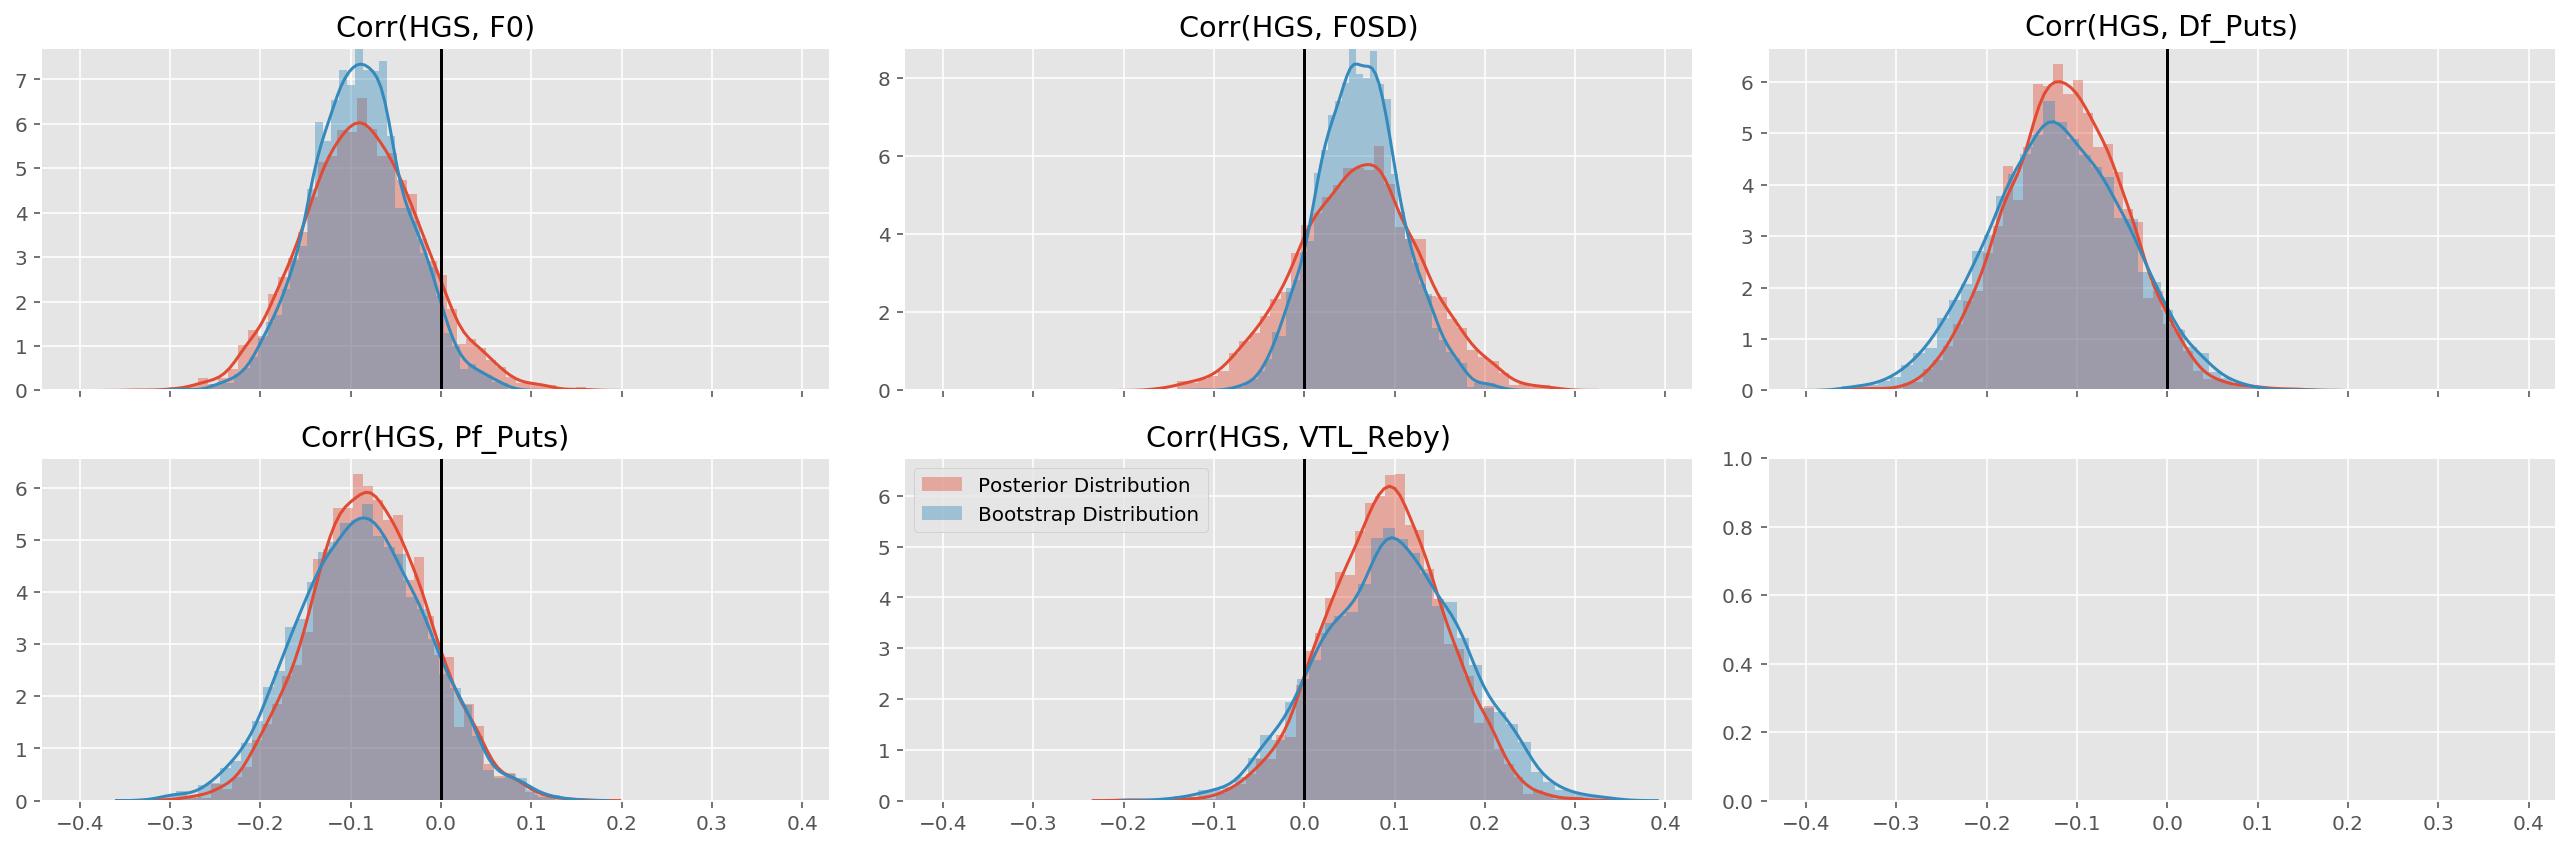

In [41]:
_,  ax = plt.subplots(2, 3, figsize=(18, 6), sharex=True)
ax1 = ax.flatten()
for i, measure in enumerate(measure_labels):
    if i>0:
        val1 = trace['corr'][:, 0, i]
        sns.distplot(val1, kde=True, ax=ax1[i-1],
                         label='Posterior Distribution')
        val2 = corr_boot[:, 0, i]
        sns.distplot(val2, kde=True, ax=ax1[i-1],
                         label='Bootstrap Distribution')
        ax1[i-1].set_title('Corr('+measure_labels[0]+', '+measure+')')
        ax1[i-1].axvline(0, color='k')
ax1[i-1].legend()
plt.tight_layout();

As shown above, we can draw the same conclusion that no correlation between handgrip strength and acoustic measures.